In [462]:
import sys
print(sys.executable)
!c:\Users\deiner.souza\AppData\Local\anaconda3\python.exe -m pip install mplfinance

c:\Users\deiner.souza\AppData\Local\anaconda3\python.exe


In [463]:
import pandas as pd
import mplfinance as mpf

In [464]:
df = pd.read_csv("15-10-2025grafic.csv")


In [465]:
df.drop(["id"],axis=1,inplace=True)
df.drop(["Unnamed: 0"],axis=1,inplace=True)
df.drop(["volume"],axis=1,inplace=True)
df.drop(["from"],axis=1,inplace=True)
df.drop(["at"],axis=1,inplace=True)
df.columns = ["Date","Open", "Close", "Low", "High"]
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'].dt.hour >= 14]
df = df[df['Date'].dt.hour <= 18]
df.set_index('Date', inplace=True)

In [466]:
#Bolinger bands indicator
df['SMA20'] = df['Close'].rolling(window=20).mean()
df['STD20'] = df['Close'].rolling(window=20).std()
df['UpperBand'] = df['SMA20'] + 2 * df['STD20']
df['LowerBand'] = df['SMA20'] - 2 * df['STD20']

df['BB_normalized'] = (df['Close'] - df['LowerBand']) / (df['UpperBand'] - df['LowerBand'])

In [467]:
df['range_total'] = df['High'].rolling(20).max() - df['Low'].rolling(20).min()
df['move_net'] = df['Close'] - df['Close'].shift(20)
df['direction_ratio'] = abs(df['move_net'] / df['range_total'])

In [468]:
n = 14  # período padrão do RSI

# Calcula variação diária
delta = df['Close'].diff()

# Separando ganhos e perdas
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

# Média móvel exponencial dos ganhos e perdas
avg_gain = gain.rolling(window=n, min_periods=n).mean()
avg_loss = loss.rolling(window=n, min_periods=n).mean()

# Evita divisão por zero
rs = avg_gain / avg_loss.replace(0, 1e-10)

# RSI
df['RSI'] = 100 - (100 / (1 + rs))

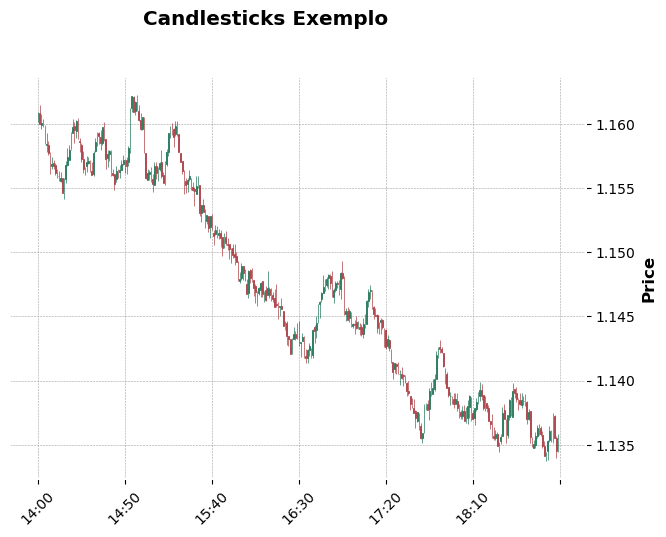

In [469]:
mpf.plot(df, type='candle', style='charles', title='Candlesticks Exemplo')

In [470]:
#mask = df["RSI"] >= 75
#df.loc[mask,"RSI>=75"] = True
#mask = df["RSI"] < 75
#df.loc[mask,"RSI>=75"] = False

#mask = df["RSI"] <= 25
#df.loc[mask,"RSI<=25"] = True
#mask = df["RSI"] > 25
#df.loc[mask,"RSI<=25"] = False


In [471]:
df["Futuro"] = df["Close"].shift(-5)
df["Futuro+10"] = df["Close"].shift(-10)


In [472]:
mask = (df["RSI"] >= 75)& (df["direction_ratio"] < 0.8)
df_superior = df.loc[mask].copy()

df_superior["Operation"] = df_superior["Close"] > df_superior["Futuro"]
df_superior["Martengale"] = df_superior["Close"] > df_superior["Futuro+10"]
df_superior["rfinal"] = df_superior["Operation"] | df_superior["Martengale"]

min_delta = pd.Timedelta(minutes=5)

# Cria uma coluna temporária com diferença de tempo em relação à linha anterior
df_superior['time_diff'] = df_superior.index.to_series().diff()

# Mantém apenas linhas cuja diferença é >= 5 minutos ou a primeira linha
df_filtered = df_superior[(df_superior['time_diff'] >= min_delta) | (df_superior['time_diff'].isna())]

# Remove a coluna temporária
df_filtered = df_filtered.drop(columns='time_diff')

df_filtered


,Open,Close,Low,High,SMA20,STD20,UpperBand,LowerBand,BB_normalized,range_total,move_net,direction_ratio,RSI,Futuro,Futuro+10,Operation,Martengale,rfinal
Date,,,,,,,,,,,,,,,,,,
2025-10-15 14:56:00,1.160945,1.161715,1.160695,1.161735,1.157972,0.002071,1.162115,1.153829,0.951734,0.00734,0.00326,0.444142,76.194939,1.157705,1.155325,True,True,True
2025-10-15 16:47:00,1.147945,1.148185,1.147125,1.148265,1.144473,0.002155,1.148784,1.140163,0.930477,0.00693,0.00458,0.660895,86.395349,1.147515,1.145425,True,True,True


In [473]:
mask = (df["RSI"] < 20) & (df["direction_ratio"] < 0.8)
df_inferior = df.loc[mask].copy()
df_inferior = df_inferior.dropna()
df_inferior["Operation"] = df_inferior["Close"] < df_inferior["Futuro"]
df_inferior["Martengale"] = df_inferior["Close"] < df_inferior["Futuro+10"]
df_inferior["rfinal"] = df_inferior["Operation"] | df_inferior["Martengale"]

In [474]:
df_inferior

,Open,Close,Low,High,SMA20,STD20,UpperBand,LowerBand,BB_normalized,range_total,move_net,direction_ratio,RSI,Futuro,Futuro+10,Operation,Martengale,rfinal
Date,,,,,,,,,,,,,,,,,,
2025-10-15 15:30:00,1.154935,1.154765,1.153585,1.155035,1.157012,0.001791,1.160594,1.153431,0.186243,0.00665,-0.00214,0.321805,19.718310,1.153125,1.151705,False,False,False
2025-10-15 15:33:00,1.155215,1.153025,1.152805,1.155215,1.156770,0.002033,1.160835,1.152704,0.039512,0.00743,-0.00390,0.524899,12.305987,1.151905,1.151355,False,False,False
2025-10-15 15:34:00,1.153025,1.153635,1.152345,1.153635,1.156560,0.002132,1.160825,1.152296,0.156985,0.00789,-0.00418,0.529785,19.523269,1.152795,1.151475,False,False,False
2025-10-15 16:24:00,1.143455,1.143225,1.142685,1.143455,1.145960,0.001263,1.148486,1.143434,-0.041380,0.00582,-0.00398,0.683849,19.903692,1.144465,1.141725,True,False,True
2025-10-15 16:25:00,1.143205,1.142075,1.142025,1.143205,1.145718,0.001510,1.148739,1.142698,-0.103097,0.00648,-0.00483,0.745370,18.479881,1.142915,1.142385,True,True,True
2025-10-15 17:24:00,1.141425,1.140695,1.140145,1.141425,1.144214,0.001644,1.147502,1.140927,-0.035310,0.00729,-0.00357,0.489712,15.117581,1.140175,1.138155,False,False,False
2025-10-15 18:03:00,1.137545,1.137215,1.137015,1.137725,1.139566,0.001720,1.143006,1.136125,0.158389,0.00618,-0.00095,0.153722,15.160350,1.138805,1.138875,True,True,True
2025-10-15 18:04:00,1.137215,1.137595,1.137035,1.137985,1.139560,0.001727,1.143014,1.136105,0.215644,0.00618,-0.00012,0.019417,11.818182,1.137465,1.139245,False,True,True
2025-10-15 18:05:00,1.137655,1.136875,1.136875,1.138065,1.139446,0.001827,1.143101,1.135791,0.148288,0.00624,-0.00227,0.363782,10.939691,1.137025,1.138795,True,True,True


In [475]:
min_delta = pd.Timedelta(minutes=5)

# Cria uma coluna temporária com diferença de tempo em relação à linha anterior
df_inferior['time_diff'] = df_inferior.index.to_series().diff()

# Mantém apenas linhas cuja diferença é >= 5 minutos ou a primeira linha
df_filtered = df_inferior[(df_inferior['time_diff'] >= min_delta) | (df_inferior['time_diff'].isna())]

# Remove a coluna temporária
df_filtered = df_filtered.drop(columns='time_diff')

df_filtered

,Open,Close,Low,High,SMA20,STD20,UpperBand,LowerBand,BB_normalized,range_total,move_net,direction_ratio,RSI,Futuro,Futuro+10,Operation,Martengale,rfinal
Date,,,,,,,,,,,,,,,,,,
2025-10-15 15:30:00,1.154935,1.154765,1.153585,1.155035,1.157012,0.001791,1.160594,1.153431,0.186243,0.00665,-0.00214,0.321805,19.718310,1.153125,1.151705,False,False,False
2025-10-15 16:24:00,1.143455,1.143225,1.142685,1.143455,1.145960,0.001263,1.148486,1.143434,-0.041380,0.00582,-0.00398,0.683849,19.903692,1.144465,1.141725,True,False,True
2025-10-15 17:24:00,1.141425,1.140695,1.140145,1.141425,1.144214,0.001644,1.147502,1.140927,-0.035310,0.00729,-0.00357,0.489712,15.117581,1.140175,1.138155,False,False,False
2025-10-15 18:03:00,1.137545,1.137215,1.137015,1.137725,1.139566,0.001720,1.143006,1.136125,0.158389,0.00618,-0.00095,0.153722,15.160350,1.138805,1.138875,True,True,True
